## Load Packages

In [110]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import os
import shutil
import random
import collections
import tifffile as tiff
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A
import warnings
warnings.filterwarnings("ignore")
# Check if GPU is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Print GPU details
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu in gpu_devices:
        print("Device:", gpu)
else:
    print("No GPU found. Make sure GPU is enabled in Kaggle settings.")
# Set TensorFlow to run on GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU enabled for TensorFlow!")
    except RuntimeError as e:
        print(e)

Num GPUs Available: 1
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU enabled for TensorFlow!


In [111]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [112]:
import rasterio
import numpy as np

file_path = "/kaggle/input/water-segmentation/data/images/10.tif"

with rasterio.open(file_path) as src:
    print(f"Total Bands: {src.count}")
    for i in range(1, src.count + 1):
        band = src.read(i)  # Read band as a NumPy array
        print(f"Band {i}: Shape {band.shape}, Min {band.min()}, Max {band.max()}")


Total Bands: 12
Band 1: Shape (128, 128), Min -83, Max 773
Band 2: Shape (128, 128), Min -103, Max 830
Band 3: Shape (128, 128), Min -14, Max 1109
Band 4: Shape (128, 128), Min -10, Max 1827
Band 5: Shape (128, 128), Min -131, Max 4152
Band 6: Shape (128, 128), Min -92, Max 3638
Band 7: Shape (128, 128), Min -29, Max 2673
Band 8: Shape (128, 128), Min 64, Max 224
Band 9: Shape (128, 128), Min 176, Max 187
Band 10: Shape (128, 128), Min 157, Max 180
Band 11: Shape (128, 128), Min 10, Max 90
Band 12: Shape (128, 128), Min 0, Max 94


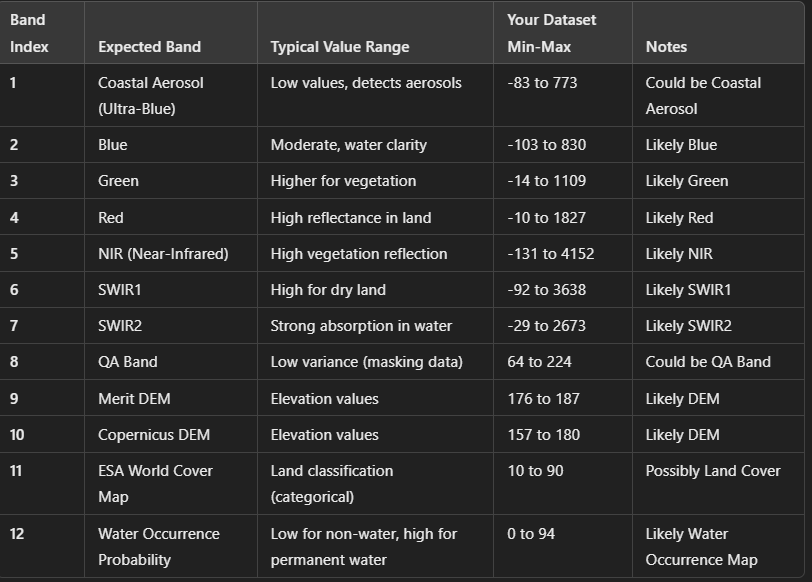

In [113]:
import os
import rasterio
import numpy as np

# Directory containing images
image_dir = "/kaggle/input/water-segmentation/data/images"

# List TIFF files in the directory
tif_files = [f for f in os.listdir(image_dir) if f.endswith(".tif")]

if not tif_files:
    raise FileNotFoundError("No TIFF files found in the directory.")

# Select the first TIFF file
tif_path = os.path.join(image_dir, tif_files[0])
print("Using file:", tif_path)

# Bands to extract (1-based indexing)
selected_data = [3,4,5,6,7,11] 

# Open the selected TIFF file
with rasterio.open(tif_path) as dataset:
    selected_data = np.stack([dataset.read(b) for b in selected_bands], axis=0)

# Check the shape
print("Extracted Data Shape:", selected_data.shape)


Using file: /kaggle/input/water-segmentation/data/images/274.tif
Extracted Data Shape: (7, 128, 128)


In [114]:
# Set the paths
image_dir = "/kaggle/input/water-segmentation/data/images"
label_dir = "/kaggle/input/water-segmentation/data/labels"

# List all images and labels
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

# Print some sample filenames
print("Sample Image Files:", image_files[:5])
print("Sample Label Files:", label_files[:5])

# Check mismatches
extra_labels = set(label_files) - set(image_files)
missing_labels = set(image_files) - set(label_files)

print("Extra Labels:", extra_labels)
print("Missing Labels:", missing_labels)


Sample Image Files: ['0.tif', '1.tif', '10.tif', '100.tif', '101.tif']
Sample Label Files: ['0.png', '1.png', '10.png', '100.png', '100_184.png']
Extra Labels: {'6.png', '112.png', '11.png', '6_248.png', '104_20.png', '21_254.png', '18_42.png', '38.png', '16_229.png', '246.png', '133.png', '214.png', '33.png', '34_239.png', '248.png', '226.png', '76_92.png', '87.png', '58.png', '242.png', '125_201.png', '142_238.png', '92_272.png', '271.png', '231.png', '116.png', '73_23.png', '35_30.png', '80_124.png', '145_164.png', '272.png', '8_73.png', '52.png', '84_76.png', '75_52.png', '18.png', '142.png', '210.png', '189.png', '102.png', '152.png', '14.png', '148_297.png', '78.png', '45_158.png', '165.png', '82.png', '208.png', '259.png', '96_154.png', '297.png', '1.png', '108.png', '110_287.png', '192.png', '268.png', '124_95.png', '91.png', '141_237.png', '275.png', '55.png', '71.png', '279.png', '201.png', '91_102.png', '92.png', '188.png', '99.png', '11_116.png', '39.png', '199.png', '48_12

### Train Valid Split

In [115]:
# List all images and labels
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

# Remove extensions to compare file names
image_names = {os.path.splitext(f)[0] for f in image_files}
label_names = {os.path.splitext(f)[0] for f in label_files}

# Find matching image-label pairs
valid_names = image_names & label_names  # Intersection of filenames

# Create a list of tuples (image_path, label_path)
data = [(os.path.join(image_dir, f"{name}.tif"), os.path.join(label_dir, f"{name}.png")) for name in valid_names]

# Shuffle data
random.shuffle(data)

# Split into 70% train and 30% validation
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)

# Separate images and labels
train_images, train_labels = zip(*train_data) if train_data else ([], [])
val_images, val_labels = zip(*val_data) if val_data else ([], [])

# Convert to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((list(train_images), list(train_labels)))
valid_dataset = tf.data.Dataset.from_tensor_slices((list(val_images), list(val_labels)))

# Check image shape
image_path = "/kaggle/input/water-segmentation/data/images/101.tif"
image = tiff.imread(image_path)
print("Image shape:", image.shape)


Image shape: (128, 128, 12)


## Data Visualization

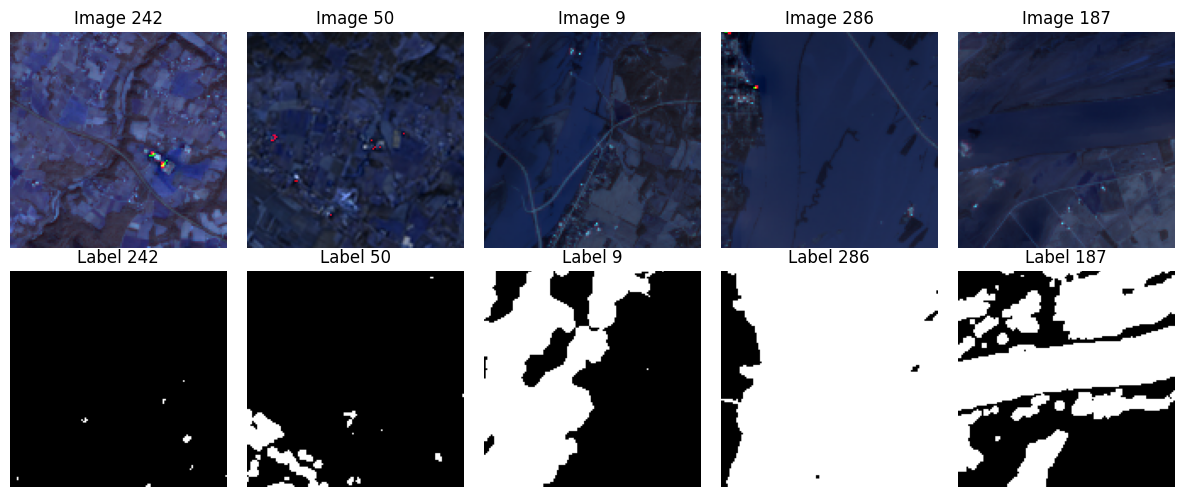

In [116]:
# Ensure matching images and labels (based on filename without extension)
image_files_dict = {os.path.splitext(f)[0]: f for f in image_files}
label_files_dict = {os.path.splitext(f)[0]: f for f in label_files}

# Find common files (ensuring correct matches)
common_keys = sorted(set(image_files_dict.keys()) & set(label_files_dict.keys()))

# Select 5 random samples from matching files
num_samples = min(5, len(common_keys))  # Avoid errors if less than 5 pairs exist
selected_keys = random.sample(common_keys, num_samples)

# Set figure size
fig, axes = plt.subplots(2, num_samples, figsize=(12, 5))

for i, key in enumerate(selected_keys):
    image_path = os.path.join(image_dir, image_files_dict[key])
    label_path = os.path.join(label_dir, label_files_dict[key])

    # Load multispectral image (12 channels)
    image = tiff.imread(image_path)

    # Convert to RGB using the first 3 channels
    image_rgb = image[:, :, :3]

    # Normalize to 8-bit (0-255)
    image_rgb = (image_rgb / image_rgb.max() * 255).astype(np.uint8)

    # Load label image in grayscale
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    # Resize images for better visualization
    target_size = (128, 128)  # Adjust size as needed
    image_rgb_resized = cv2.resize(image_rgb, target_size, interpolation=cv2.INTER_LINEAR)
    label_resized = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)

    # Display the image
    axes[0, i].imshow(image_rgb_resized)
    axes[0, i].set_title(f"Image {key}")
    axes[0, i].axis("off")

    # Display the label
    axes[1, i].imshow(label_resized, cmap="gray")
    axes[1, i].set_title(f"Label {key}")
    axes[1, i].axis("off")

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


## Data Preprocessing

In [117]:
import tensorflow as tf
import cv2
import numpy as np
import rasterio

# --- SELECTED BANDS (Green,Red,NIR,SWIR1,SWIR2,Water Occurrence,DEM) ---
SELECTED_BANDS = [3,4,5,6,7,11] # 1-based indexing in rasterio
    
def load_and_preprocess(image_path, label_path):
    image_path = image_path.numpy().decode('utf-8')
    label_path = label_path.numpy().decode('utf-8')

    # Read multispectral image using rasterio
    with rasterio.open(image_path) as src:
        image = np.stack([src.read(b) for b in SELECTED_BANDS], axis=-1)  # Shape: (H,W,8)

    # Resize image (each band separately to avoid distortion)
    resized_bands = [cv2.resize(image[:, :, i], (128, 128), interpolation=cv2.INTER_CUBIC) for i in range(image.shape[-1])]
    image = np.stack(resized_bands, axis=-1)  # Shape: (128,128,8)

    # Normalize image (adjust based on data characteristics)
    image =image = image.astype(np.float32) / 255.0 
    
    # Read label (grayscale mask)
    label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    if label is None:
        raise ValueError(f"Error loading label: {label_path}")

    # Resize label
    label = cv2.resize(label, (128, 128), interpolation=cv2.INTER_NEAREST)

    # Ensure label has correct shape (128, 128, 1)
    if len(label.shape) == 2:
        label = np.expand_dims(label, axis=-1)

    return image, label

# --- WRAPPER FOR TENSORFLOW DATASET ---
def load_and_preprocess_wrapper(image_path, label_path):
    image, label = tf.py_function(
        func=load_and_preprocess, 
        inp=[image_path, label_path], 
        Tout=[tf.float32, tf.float32]
    )

    # Set known shapes
    image.set_shape((128, 128, len(SELECTED_BANDS)))  # Now (128, 128, 6)
    label.set_shape((128, 128, 1))

    return image, label

# --- APPLY TO DATASET ---
train_dataset_prep = train_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset_prep = valid_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

# --- BATCH, SHUFFLE, AND PREFETCH ---
BATCH_SIZE = 32
train_dataset_prep = train_dataset_prep.batch(BATCH_SIZE).shuffle(len(train_images)).prefetch(tf.data.AUTOTUNE)
valid_dataset_prep = valid_dataset_prep.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [118]:
train_dataset_prep

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

## Modeling


In [119]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def get_model(input_shape=(128,128,6), dropout_rate=0.3):
    inputs = keras.Input(input_shape)

    # Encoder
    x = layers.Conv2D(64, 3, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    
    x = layers.Conv2D(128, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    
    x = layers.Conv2D(256, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    
    x = layers.Dropout(dropout_rate)(x)  # Regularization

    # Decoder
    x = layers.Conv2DTranspose(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(256, 3, padding="same", strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(128, 3, padding="same", strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(64, 3, padding="same", strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    return model

# Create and summarize the model
model = get_model()
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 64, 64, 64)          │           3,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_72               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_72 (ReLU)                      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 64, 64, 64)          │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_73               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_73 (ReLU)                      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 128)         │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_74               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_74 (ReLU)                      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 32, 32, 128)         │         147,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_75               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_75 (ReLU)                      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 16, 16, 256)         │         294,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_76               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_76 (ReLU)                      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 16, 16, 256)         │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_77               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,886,081 (11.01 MB)

 Trainable params: 2,882,497 (11.00 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [120]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Intersection over Union (IoU)
def iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

# F1 Score (Dice Coefficient)
def f1_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = K.sum(y_true * y_pred)  # True Positives
    fp = K.sum(y_pred) - tp  # False Positives
    fn = K.sum(y_true) - tp  # False Negatives
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())
import tensorflow as tf

# Custom Dice coefficient metric
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Flatten the tensors to calculate Dice coefficient
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    return (2. * intersection + smooth) / (union + smooth)

In [121]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy",dice_coefficient, iou]
)

In [122]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_unet_model.keras",  # File name
    monitor="val_iou",  # Track validation IoU
    mode="max",  # Save when IoU is highest
    save_best_only=True,
    verbose=1
)
history = model.fit(
    train_dataset_prep,  # Training data
    validation_data=valid_dataset_prep,  # Validation data
    epochs=60,
    callbacks=[checkpoint_callback]
)

Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.6655 - dice_coefficient: 0.3281 - iou: 0.1344 - loss: 0.6317
Epoch 1: val_iou improved from -inf to 0.00386, saving model to best_unet_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6688 - dice_coefficient: 0.3302 - iou: 0.1382 - loss: 0.6278 - val_accuracy: 0.7590 - val_dice_coefficient: 0.3137 - val_iou: 0.0039 - val_loss: 0.6894
Epoch 2/60
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7831 - dice_coefficient: 0.4229 - iou: 0.3487 - loss: 0.4964
Epoch 2: val_iou did not improve from 0.00386
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.7891 - dice_coefficient: 0.4295 - iou: 0.3660 - loss: 0.4898 - val_accuracy: 0.7678 - val_dice_coefficient: 0.3134 - val_iou: 2.5054e-04 - val_loss: 0.6862
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8623 - dice_coefficient: 0.5249 - iou: 0.5605 - loss: 0.3923
Epoch 3: val_iou improved from 0.00386 to 0.02842, saving model to best_unet_model.

## Load Best Model

In [123]:
# Load the best saved model
best_model = tf.keras.models.load_model("best_unet_model.keras", custom_objects={"iou": iou, "dice_coefficient": dice_coefficient})

# Print the summary of the best model
best_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 64, 64, 64)          │           3,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_72               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_72 (ReLU)                      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 64, 64, 64)          │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_73               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_73 (ReLU)                      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 128)         │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_74               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_74 (ReLU)                      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 32, 32, 128)         │         147,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_75               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_75 (ReLU)                      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 16, 16, 256)         │         294,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_76               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_76 (ReLU)                      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 16, 16, 256)         │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_77               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,651,077 (33.00 MB)

 Trainable params: 2,882,497 (11.00 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 5,764,996 (21.99 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


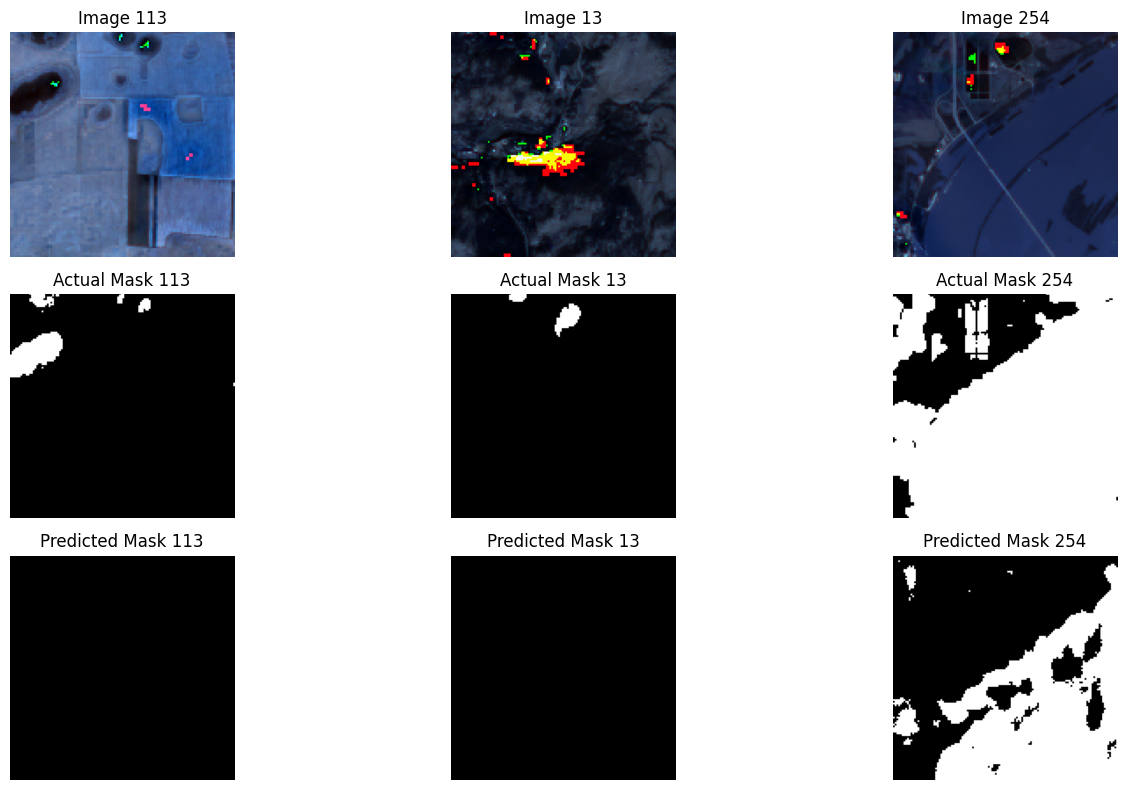

In [124]:
# Function to preprocess image (normalize)
def preprocess_image(image):
    """Normalize the image to [0,1] range for model prediction."""
    image = image.astype(np.float32) / 255.0  # Normalize to 0-1
    return image

# Ensure matching images and labels (based on filename without extension)
image_files_dict = {os.path.splitext(f)[0]: f for f in image_files}
label_files_dict = {os.path.splitext(f)[0]: f for f in label_files}

# Find common files (ensuring correct matches)
common_keys = sorted(set(image_files_dict.keys()) & set(label_files_dict.keys()))

# Select 3 random samples from matching files
num_samples = min(3, len(common_keys))  # Avoid errors if less than 3 pairs exist
selected_keys = random.sample(common_keys, num_samples)

# Set figure size
fig, axes = plt.subplots(3, num_samples, figsize=(15, 8))

for i, key in enumerate(selected_keys):
    image_path = os.path.join(image_dir, image_files_dict[key])
    label_path = os.path.join(label_dir, label_files_dict[key])

    # Load multispectral image (12 channels)
    image = tiff.imread(image_path)

    # Convert to RGB using the first 3 channels
    image_rgb = image[:, :, :3]

    # Normalize to 8-bit (0-255) for visualization
    image_rgb = (image_rgb / image_rgb.max() * 255).astype(np.uint8)

    # Preprocess image for model prediction (only 6 channels)
    image_6_channels = image[:, :, :6]  # Select only the first 6 channels
    input_image = preprocess_image(image_6_channels)  # Normalize the image
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

    # Get model prediction
    prediction = best_model.predict(input_image)[0]  # Remove batch dimension
    prediction = (prediction > 0.5).astype(np.uint8)  # Threshold for binary mask

    # Load label image in grayscale
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    # Resize images for better visualization
    target_size = (128, 128)  # Adjust size as needed
    image_rgb_resized = cv2.resize(image_rgb, target_size, interpolation=cv2.INTER_LINEAR)
    label_resized = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)
    pred_resized = cv2.resize(prediction, target_size, interpolation=cv2.INTER_NEAREST)

    # Display the input image
    axes[0, i].imshow(image_rgb_resized)
    axes[0, i].set_title(f"Image {key}")
    axes[0, i].axis("off")

    # Display the ground truth mask
    axes[1, i].imshow(label_resized, cmap="gray")
    axes[1, i].set_title(f"Actual Mask {key}")
    axes[1, i].axis("off")

    # Display the predicted mask
    axes[2, i].imshow(pred_resized, cmap="gray")
    axes[2, i].set_title(f"Predicted Mask {key}")
    axes[2, i].axis("off")

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()
